## Climate Change: Earth Surface Temperature Data




In this notebook we explore a dataset of monthly temperatures across the globe dated from 1750 to 2015. We will investigate if temperatures have been rising and we will compare Machine Learning models to predict accurately future temperatures in countries an cities of choice.     
    
The dataset contains 3 csv files:

`GlobalLandTemperaturesByCity.csv`

`GlobalLandTemperaturesByCountry.csv`

`GlobalTemperatures.csv`

In the first part we analyze the dataset to verify some statistical properties, like the stationarity. Stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. 

Then we check is the data is seasonal, as we expect from land and sea temperatures.

#### Importing required modules 

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### **Loading the datasets**

In [2]:
import zipfile
with zipfile.ZipFile("data/GlobalTemperatures.csv.zip","r") as zip_ref:
    zip_ref.extractall("data")
with zipfile.ZipFile("data/GlobalLandTemperaturesByCountry.csv.zip","r") as zip_ref:
    zip_ref.extractall("data")    

In [48]:
global_temperatures = pd.read_csv('data/GlobalTemperatures.csv')
country_temperatures = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
SA = pd.read_csv('data/SATemperaturesbyCity.csv')

In [45]:
#city_temperatures = pd.read_csv('data/GlobalLandTemperaturesByCity.csv')
#SA = city_temperatures[city_temperatures.Country == 'South Africa']
#SA.set_index('dt', inplace=True)
#SA.to_csv('data/SATemperaturesbyCity.csv')

In [46]:
#SA.to_csv('data/SATemperaturesbyCity.csv')

In [36]:
SA.shape

(94050, 10)

In [54]:
SA.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1857-01-01,18.581,1.812,Alberton,South Africa,26.52S,28.66E
1,1857-02-01,18.912,1.641,Alberton,South Africa,26.52S,28.66E
2,1857-03-01,16.969,1.573,Alberton,South Africa,26.52S,28.66E
3,1857-04-01,13.262,1.555,Alberton,South Africa,26.52S,28.66E
4,1857-05-01,10.260,1.477,Alberton,South Africa,26.52S,28.66E


In [37]:
country_temperatures.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month
0,1743-11-01,4.384,2.294,Åland,1743,11
1,1743-12-01,NaN,NaN,Åland,1743,12
2,1744-01-01,NaN,NaN,Åland,1744,1
3,1744-02-01,NaN,NaN,Åland,1744,2
4,1744-03-01,NaN,NaN,Åland,1744,3


In [38]:
country_temperatures.shape

(577462, 6)

In [39]:
global_temperatures.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty,year,month
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN,1750,1
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN,1750,2
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN,1750,3
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN,1750,4
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN,1750,5


In [40]:
global_temperatures.shape

(3192, 11)

In [55]:
# Convert dt from string to datetime
global_temperatures['dt'] = pd.to_datetime(global_temperatures.dt)
global_temperatures['year'] = global_temperatures['dt'].map(lambda x:x.year)
global_temperatures['month'] = global_temperatures['dt'].map(lambda x:x.month)

country_temperatures['dt'] = pd.to_datetime(country_temperatures.dt)
country_temperatures['year'] = country_temperatures['dt'].map(lambda x:x.year)
country_temperatures['month'] = country_temperatures['dt'].map(lambda x:x.month)

In [56]:
# Convert dt from string to datetime
SA['dt'] = pd.to_datetime(SA.dt)
SA['year'] = SA['dt'].map(lambda x:x.year)
SA['month'] = SA['dt'].map(lambda x:x.month)

# Is The Global Temperature Really Rising??

In [57]:
# We take the avg temperature per year
global_mean=global_temperatures.groupby(['year'])['LandAverageTemperature'].mean().reset_index()
global_mean.dropna(inplace=True)

In [58]:
global_mean.head()

,year,LandAverageTemperature
0,1750,8.719364
1,1751,7.976143
2,1752,5.779833
3,1753,8.388083
4,1754,8.469333


In [59]:
# Visualize Plot
trace=go.Scatter(
    x=global_mean['year'],
    y=global_mean['LandAverageTemperature'],
    mode='lines',
    )
data=[trace]

py.iplot(data, filename='line-mode')

#### Dicky Fuller Stationarity Test

In [60]:
# Dicky Fuller Stationarity Test (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1911068)
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4], index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        

adf_test(global_mean.LandAverageTemperature, title='DFT')

Augmented Dickey-Fuller Test: DFT
ADF test statistic       -0.191872
p-value                   0.939484
# lags used              15.000000
# observations          250.000000
critical value (1%)      -3.456781
critical value (5%)      -2.873172
critical value (10%)     -2.572969
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Time Series Deconstruction:
#### 1. Trend: Reflects long term progression of series
#### 2. Seasonality: Reflects seasonal variation and checks if seasonal pattern exists in the time series
#### 3. Residual: Shows irregular component (or "noise") at time t, which describes random, irregular influences

In [61]:
ts = global_temperatures[['dt','LandAverageTemperature']]
rng = pd.date_range(start='1901-01-01', end='2015-12-01', freq = 'MS')

data = ts[ts.dt.dt.year>1900].LandAverageTemperature.values
series = pd.Series(data=data, index=rng)
len(data), len(series)


(1380, 1380)

<Figure size 1080x576 with 0 Axes>

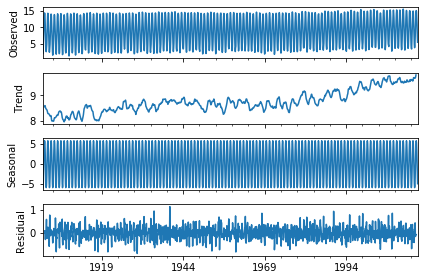

In [62]:
## ETS Graph (Error Trend Seasonality)

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(series, model='additive')
plt.figure(figsize=(15,8))
result.plot();

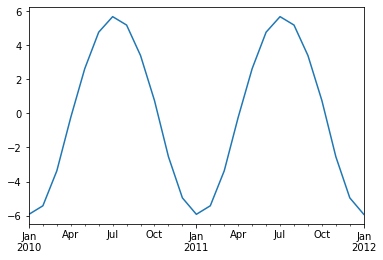

In [63]:
# There exists 12 months seasonality in the dataset
result.seasonal.loc['2010-01-01':'2012-01-01'].plot()

In [64]:
# Visualize Plot with Avg temperature starting from 1900, as measurements were more accurate 
trace=go.Scatter(
    x=global_mean[global_mean['year'] > 1900].year,
    y=global_mean[global_mean['year'] > 1900].LandAverageTemperature,
    mode='lines',
    )
data=[trace]

py.iplot(data, filename='line-mode')

## Now we can look at measurements in January and July

In [66]:
dict_month = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
#global_temperatures['month']=global_temperatures['month'].map(dict_month)

In [65]:
def plot_month(month1,month2):
    a = global_temperatures[global_temperatures['month'] == month1]
    b = global_temperatures[global_temperatures['month'] == month2]
    trace0 = go.Scatter(
    x = a['year'],
    y = a['LandAverageTemperature'],
    mode = 'lines',
    name = dict_month[month1]
    )
    
    trace1 = go.Scatter(
    x = b['year'],
    y = b['LandAverageTemperature'],
    mode = 'lines',
    name = dict_month[month2]
    )
    data = [trace0,trace1]
    py.iplot(data, filename='line-mode')
    
plot_month(1,7)


Looks like July temperatures have always been higher. What if you split the dataset between the northern and southern emisphere and draw this graph on the two datasets?

## Interactive Map

In [67]:
# We remove the duplicated countries and the continents (in the analysis, we don't consider the presence of 
# colonies at this the countries) and countries for which no information about the temperature

country_temp = country_temperatures[~country_temperatures['Country'].isin(
    ['Denmark', 'France', 'Europe', 'Netherlands','United Kingdom', 'Africa', 'Europe', 'Asia', 'South America', 'North America'])]

country_temp = country_temp.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

#Let's average temperature for each country
countries = np.unique(country_temp['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(country_temp[country_temp['Country'] == country]['AverageTemperature'].mean())

In [68]:
data = [ dict(
        type = 'choropleth',
        #autocolorscale = True,
        #colorscale = 'RdYlGn',
        #reversescale = True,
        showscale = True,
        locations = countries,
        z = mean_temp,
        locationmode = 'country names', 
        marker = dict(
            line = dict(color = 'rgb(200,200,200)', width = 0.5)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = 'Temperature')
            )
       ]

layout = dict(
    title = 'Average Temperature By Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'Mercator',
            
        ),
            ),
        )
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap2010')

Let’s look at the chart of annual temperature changes in certain continents (we take into consideration one country per continent and mark Greenland as the coldest place on Earth).

In [69]:
continents = ['Africa', 'Europe', 'North America', 'South America', 'Australia', 'Asia']
continents_temps = country_temperatures[country_temperatures.Country.isin(continents)]
continents_temps['dt'] = pd.to_datetime(continents_temps.dt)
continents_temps['year'] = continents_temps['dt'].map(lambda x:x.year)
continents_temps['month'] = continents_temps['dt'].map(lambda x:x.month)

continents_temps = continents_temps[continents_temps.year > 1900].groupby(['Country', 'year'])['AverageTemperature'].mean().reset_index().sort_values(by=['Country', 'year'])


In [70]:
traces = []
#colors = ['rgb(0, 255, 255)', 'rgb(255, 0, 255)', 'rgb(0, 0, 0)',
#          'rgb(255, 0, 0)', 'rgb(0, 255, 0)', 'rgb(0, 0, 255)']
colors = ['red', 'blue', 'black', 'green', 'pink', 'magenta']
years = continents_temps.year.unique()
for i, continent in enumerate(continents):
    traces.append(go.Scatter(
        x=years,
        y=continents_temps[continents_temps.Country == continent].AverageTemperature.values,
        mode='lines',
        name=continent,
        line=dict(color=colors[i]),
    ))
    
    
layout = go.Layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average Land Temperature on the Continents',)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

## Temperature Difference By Country

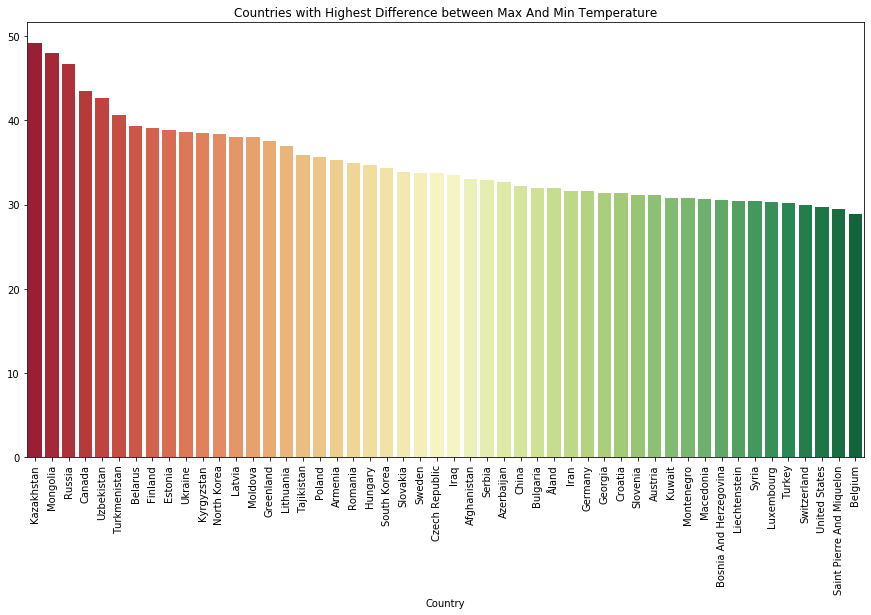

In [71]:
max_temps = country_temp[country_temp.year > 1900].groupby('Country')['AverageTemperature'].max()
min_temps = country_temp[country_temp.year > 1900].groupby('Country')['AverageTemperature'].min()
differences = (max_temps - min_temps).sort_values(ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(y=differences.values[:50], x=differences.index[:50], palette='RdYlGn').set_title('Countries with Highest Difference between Max And Min Temperature')
plt.xticks(rotation=90);


In [72]:
# And let's have a look at tge world map with temperature differences
data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = 'Viridis',
        reversescale = True,
        showscale = True,
        locations = differences.index,
        z = differences.values,
        locationmode = 'country names',
        text = differences.index,
        marker = dict(
            line = dict(color = 'rgb(200,200,200)', width = 0.5)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = 'Temperature Difference')
            )
       ]

layout = dict(
    title = 'Temperature Difference By Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'Mercator',
            
        ),
            ),
        )
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap2010')

# What about   South Africa ?

In [73]:
#SA = city_temperatures[city_temperatures.Country == 'South Africa']
# Consider name changes
SA['City'].replace({'Pietersburg':'Polokwane'}, inplace=True)
#SA['month'] = SA.month.map(dict_month)
SA.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1857-01-01,18.581,1.812,Alberton,South Africa,26.52S,28.66E,1857,1
1,1857-02-01,18.912,1.641,Alberton,South Africa,26.52S,28.66E,1857,2
2,1857-03-01,16.969,1.573,Alberton,South Africa,26.52S,28.66E,1857,3
3,1857-04-01,13.262,1.555,Alberton,South Africa,26.52S,28.66E,1857,4
4,1857-05-01,10.260,1.477,Alberton,South Africa,26.52S,28.66E,1857,5


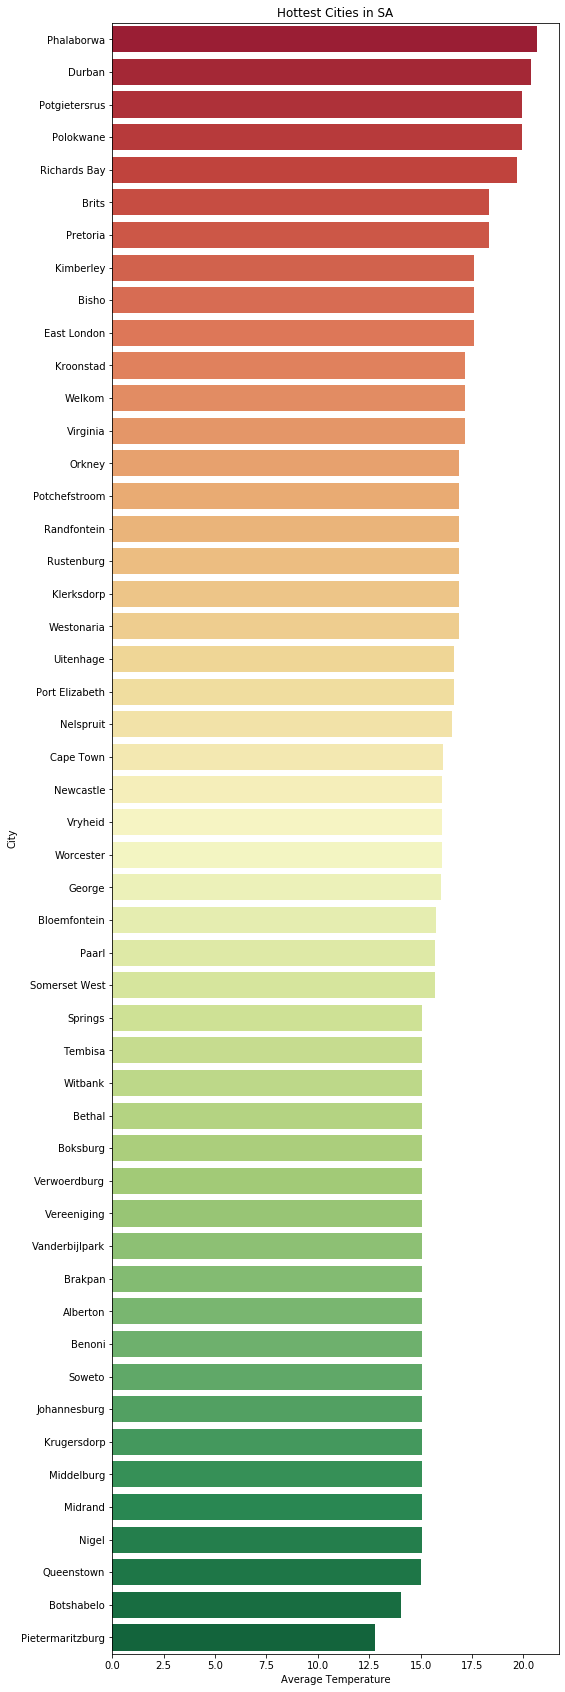

In [74]:
sa_avg_temps = SA.groupby(['City'])['AverageTemperature'].mean().reset_index().sort_values(by='AverageTemperature',ascending=False)
#sa_avg_temps
plt.subplots(figsize=(8,30))
sns.barplot(y='City',  x='AverageTemperature', data=sa_avg_temps, palette='RdYlGn').set_title('Hottest Cities in SA')
plt.xlabel('Average Temperature');

In [75]:
major_cities=SA[SA['City'].isin(['Johannesburg','Cape Town','Bloemfontein','Rustenburg', 'Nelspruit', 'Durban','Port Elizabeth','Pretoria','Polokwane','East London'])]

heatmap=major_cities.groupby(['City','month'])['AverageTemperature'].mean().reset_index().sort_values(by='month')
heatmap


,City,month,AverageTemperature
0,Bloemfontein,1,22.729758
36,East London,1,20.251076
12,Cape Town,1,19.862490
48,Johannesburg,1,19.595580
108,Rustenburg,1,21.910490
...,...,...,...
35,Durban,12,21.697168
23,Cape Town,12,18.890135
11,Bloemfontein,12,21.731968
107,Pretoria,12,22.174439


In [76]:
trace = go.Heatmap(z=heatmap['AverageTemperature'],
                   x=heatmap['month'].map(dict_month),
                   y=heatmap['City'],
                  colorscale='Viridis')
data=[trace]
layout = go.Layout(
    title='Average Temperature Of Major SA Cities By Month',
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

# Sequence Data



A sequence is any type of data that is in a particular order in which one thing follows another. 
Sequence data comes in many forms. Audio is a natural sequence. You can chop up an audio spectrogram into chunks and feed that into a machine learning model. Text is another form of sequences. You can break Text up into a sequence of characters or a sequence of words.

The simplest machine learning problem involving a sequence is a one to one problem.
<br>
![One2one](one2one.png "One 2 One")



In this case, we have one data input or tensor to the model and the model generates a prediction with the given input.

We can extend this formulation to allow for the model to make use of the past values of the input and the output. Now the output of the model is now fed back to the model as a new input. The model now can generate a new output and we can continue like this indefinitely.

![Many to One](many2one.png "Many 2 One")

There are called Recurrent Neural Networks (RNNs).
RNNs can retain state from one iteration to the next by using their own output as input for the next step.


A Time Series is a sequence where the data is in order, with a fixed time-difference between occurrence of successive data points. 
A Recurrent Neural Netowrk is a particular type of neural mnetwork that is  good at processing sequence data for predictions. That's because they implement a concept called sequential memory.
Sequential memory is a mechanism that makes it easier for the brain to recognize sequence patterns.


Traditional neural networks have an input layer, one or more hidden layers, and an output layer.

![Traditional Feed-Forward Neural Network](ffnn.png "Traditional Feed-Forward Neural Network")

Now we want to get a feed-forward neural network to be able to use previous information to effect later results. So we add a loop in the neural network that can pass prior information to later stages.

![RNN](rnn.gif "RNN")

Recurrent Neural Networks suffer from short-term memory. If a sequence is long enough, they’ll have a hard time carrying information from earlier time steps to later ones. So for us it will be diifcult to predict temperatures in 2020 while remembering what happened in the previous years.

To solve this problem Long Short Term Memory Networks (LSTM) were introduced. They have internal mechanisms called gates that can regulate the flow of information. These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. LSTM are capable or memorizing and carrying a "state". You can think of it as the “memory” of the network. So even information from the earlier time steps can make it’s way to later time steps, reducing the effects of short-term memory. As the cell state goes on its journey, information get’s added or removed to the cell state via gates.
![LSTM](lstm.png "LSTM")


If you want to know more, you can have a look at the followig articles: 

[Illustrated Guide to recurrent Neural Networks by Michael Nguyen](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)

[Illustrated Guide to LSTM’s and GRU’s: A step by step explanation by Michael Nguyen](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

[A Guide For Time Series Prediction Using Recurrent Neural Networks (LSTMs) by Neelabh Pant
](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)

[Using LSTMs to forecast time-series by Ravindra Kompella
](https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f)

In [77]:
global_mean.LandAverageTemperature.values

array([8.71936364, 7.97614286, 5.77983333, 8.38808333, 8.46933333,
       8.35558333, 8.84958333, 9.022     , 6.74358333, 7.98508333,
       7.18516667, 8.7725    , 8.6065    , 7.49675   , 8.40033333,
       8.25191667, 8.40566667, 8.2215    , 6.78133333, 7.69458333,
       7.69191667, 7.85316667, 8.1935    , 8.2215    , 8.77216667,
       9.18308333, 8.304     , 8.25625   , 8.54225   , 8.98325   ,
       9.43291667, 8.10258333, 7.90125   , 7.68083333, 7.862     ,
       7.363     , 8.25816667, 8.03183333, 8.44716667, 8.33416667,
       7.98233333, 8.23425   , 8.089     , 8.22916667, 8.526     ,
       8.35033333, 8.271     , 8.51058333, 8.67025   , 8.50575   ,
       8.48425   , 8.58966667, 8.57816667, 8.503     , 8.84483333,
       8.56275   , 8.43408333, 8.28141667, 7.62683333, 7.07641667,
       6.92266667, 6.8595    , 7.04625   , 7.73991667, 7.59175   ,
       7.23933333, 6.9375    , 6.97566667, 7.82891667, 7.36916667,
       7.61625   , 8.09008333, 8.18833333, 7.71866667, 8.54716

### Divide the dataset into training and validation sets
It is very important when you do time series to split train and test with respect to a certain date. So, you don’t want your test data to come before your training data.

Setting training set from: January 1901 to December 2000

Setting validation set from: January 2001 to December 2015

In [84]:
ts = global_temperatures[['dt','LandAverageTemperature']]
rng = pd.date_range(start='1901-01-01', end='2015-12-01', freq = 'MS')

data = ts[ts.dt.dt.year>1900].LandAverageTemperature.values
series = pd.Series(data=data, index=rng)

In [85]:
dataset = pd.DataFrame(data=data, index=rng)

train, test = dataset.iloc[:-180], dataset.iloc[-180:]
train.shape, test.shape

((1200, 1), (180, 1))

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', length=1380, freq='MS')

The next thing to do is normalize the dataset. You only need to fit and transform your training data and just transform your test data. The reason you do that is you don’t want to assume that you know the scale of your test data

In [87]:
# Scaling values
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

sc = StandardScaler()
sc.fit(train)

scaled_train = sc.transform(train)
scaled_test = sc.transform(test)
#X_train = scaled_train[:-1]
#y_train = scaled_train[1:]

#X_test = scaled_test[:-1]
test_y = scaled_test[1:]


In [88]:
test_y.shape

(179, 1)

### Linear Regression

In [210]:
# Linear Regression
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#predict the test set results
y_pred = regressor.predict(X_test)

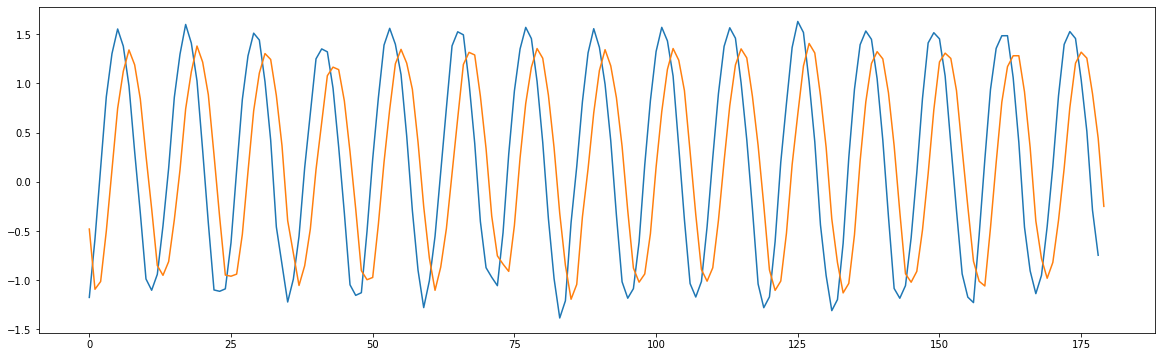

In [217]:
X_test_NN = np.insert(X_test,0,X_train[-1][0]).reshape(-1,1)
predictions = regressor.predict(X_test_NN)
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)

In [219]:
# Metrics 
from sklearn.metrics import mean_squared_error, r2_score
predictions_inv_scaled = sc.inverse_transform(predictions)

print('MSE: %f'%mean_squared_error(test,predictions_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(test,predictions_inv_scaled)))
print('R-Squared: %f'%r2_score(test,predictions_inv_scaled))


MSE: 4.408666
RMSE: 2.099682
R-Squared: 0.741225


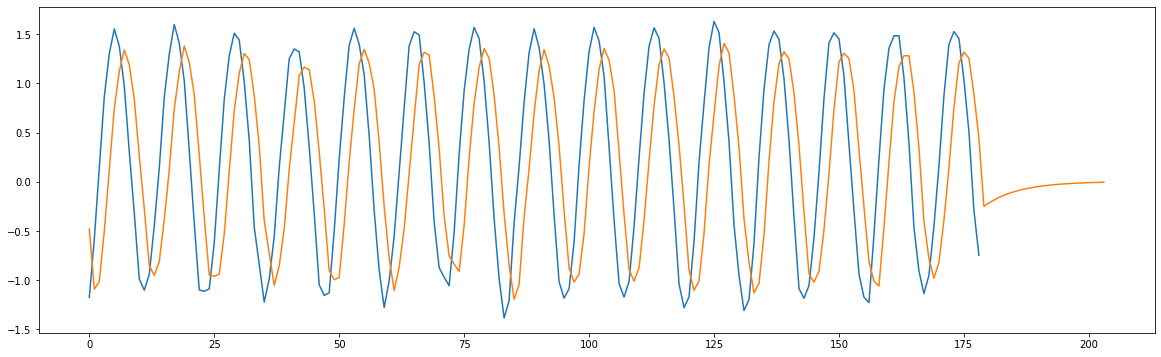

In [220]:
predictions.shape, y_test.shape
last = predictions[-1].reshape(-1,1) # This is the value predicted for 2016
for i in range(24):
    next_month = regressor.predict(last)
    predictions=np.append(predictions, next_month)
    last = next_month
#print('Prediction for July 2016 is', sc.inverse_transform(last)[0][0])

plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)  

What does it mean?

#### Using a FeedForward Neural Network
A fully Connected Model is a simple neural network model which is built as a simple regression model that will take one input and will spit out one output. This basically takes the temperature from the previous month and forecasts the temperature of the next month.


In [221]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout
#from tensorflow.keras.optimizers import Adam
#import tensorflow.keras.backend as K

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam

#K.clear_session()
np.random.seed(7)
ff_model = Sequential()
ff_model.add(Dense(7, input_dim=1, activation='relu'))
ff_model.add(Dense(1, activation='relu'))
#ff_model.compile(loss='mean_squared_error', optimizer=adam(lr=0.001))
ff_model.compile(loss='mse', optimizer=Adam(lr=0.001))
ff_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Train on 1199 samples, validate on 179 samples
Epoch 1/50
1199/1199 [==============================] - 3s 2ms/step - loss: 1.3200 - val_loss: 1.0822
Epoch 2/50
1199/1199 [==============================] - 0s 99us/step - loss: 1.0877 - val_loss: 0.9229
Epoch 3/50
1199/1199 [==============================] - 0s 107us/step - loss: 0.9142 - val_loss: 0.7972
Epoch 4/50
1199/1199 [==============================] - 0s 104us/step - loss: 0.8120 - val_loss: 0.6955
Epoch 5/50
1199/1199 [==============================] - 0s 104us/step - loss: 0.7484 - val_loss: 0.6099
Epoch 6/50
1199/1199 [==============================] - 0s 105us/step - loss: 0.7015 - val_loss: 0.5502
Epoch 7/50
1199/1199 [==============================] - 0s 109us/step - loss: 0.6719 - val_loss: 0.5124
Epoch 8/50
1199/1199 [==============================] - 0s 105us/step - loss: 0.6559 - val_loss: 0.4946
Epoch 9/50
1199/1199 [==============================] - 0s 142us/step - loss: 0.6491 - val_loss: 0.4851
Epoch 10/50
1199/119

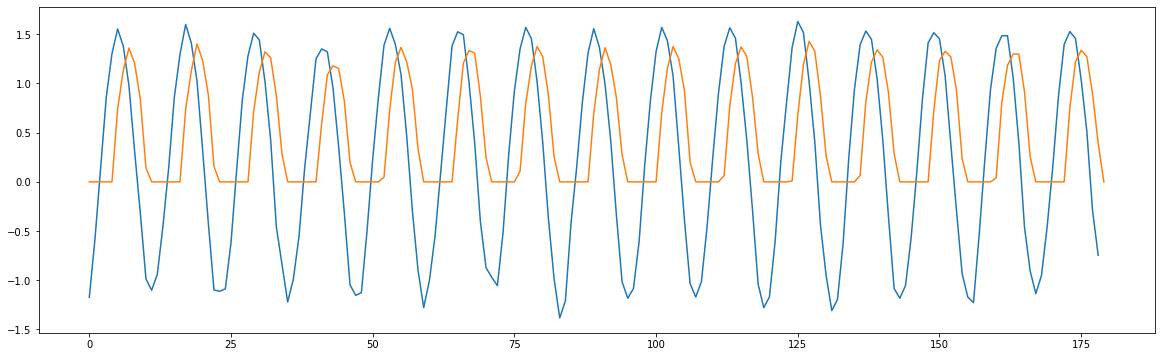

In [222]:
# Predict temperature for Jan 2016

X_test_NN = np.insert(X_test,0,X_train[-1][0]).reshape(-1,1)
predictions = ff_model.predict(X_test_NN)
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)

In [224]:
predictions_inv_scaled = sc.inverse_transform(predictions)
print('MSE: %f'%mean_squared_error(test,predictions_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(test,predictions_inv_scaled)))
print('R-Squared: %f'%r2_score(test,predictions_inv_scaled))

MSE: 8.467734
RMSE: 2.909937
R-Squared: 0.502971


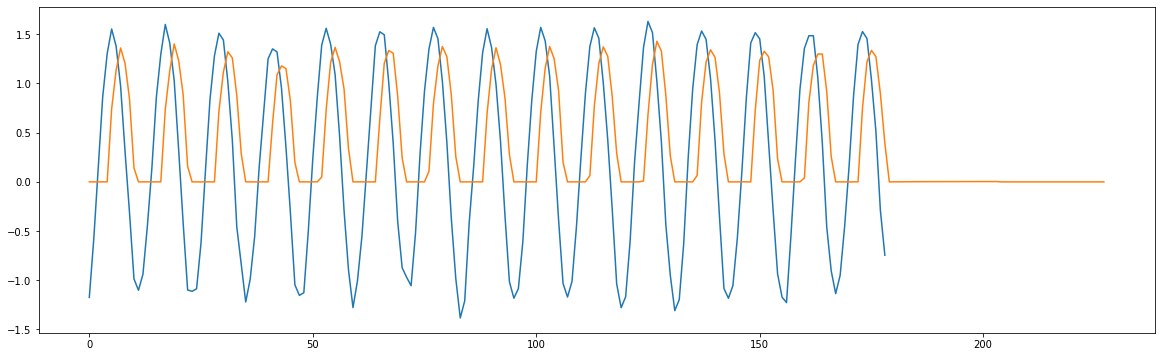

In [227]:
predictions.shape, y_test.shape
last = predictions[-1].reshape(-1,1) # This is the value predicted for 2016
for i in range(24):
    next_month = ff_model.predict(last)
    predictions=np.append(predictions, next_month)
    last = next_month
#print('Prediction for July 2016 is', sc.inverse_transform(last)[0][0])

plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)  

The model is not good. It essentially is repeating the previous values and there is a slight shift. The fully connected model is not able to predict the future from the single previous value. 

### Using LSTMs
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [228]:
# LSTM needs to define (Batch Size x Nbr of Batches x Features)
# 3-D tensor
X_train_t = X_train[:,None]
X_test_t = X_test[:,None]
X_train_t.shape, X_test_t.shape

((1199, 1, 1), (179, 1, 1))

In [229]:
np.random.seed(7)

#K.clear_session()
lstm_model = Sequential()

lstm_model.add(LSTM(20, input_shape=(1,1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
lstm_model.fit(X_train_t, y_train, validation_data=(X_test_t, y_test), epochs=20, verbose=2)

Train on 1199 samples, validate on 179 samples
Epoch 1/20
 - 3s - loss: 1.0367 - val_loss: 0.9797
Epoch 2/20
 - 0s - loss: 0.9058 - val_loss: 0.8541
Epoch 3/20
 - 0s - loss: 0.7753 - val_loss: 0.7189
Epoch 4/20
 - 0s - loss: 0.6383 - val_loss: 0.5795
Epoch 5/20
 - 0s - loss: 0.5036 - val_loss: 0.4538
Epoch 6/20
 - 0s - loss: 0.3901 - val_loss: 0.3531
Epoch 7/20
 - 0s - loss: 0.3141 - val_loss: 0.2937
Epoch 8/20
 - 0s - loss: 0.2748 - val_loss: 0.2652
Epoch 9/20
 - 0s - loss: 0.2610 - val_loss: 0.2557
Epoch 10/20
 - 0s - loss: 0.2570 - val_loss: 0.2530
Epoch 11/20
 - 0s - loss: 0.2563 - val_loss: 0.2515
Epoch 12/20
 - 0s - loss: 0.2559 - val_loss: 0.2511
Epoch 13/20
 - 0s - loss: 0.2558 - val_loss: 0.2512
Epoch 14/20
 - 0s - loss: 0.2558 - val_loss: 0.2512
Epoch 15/20
 - 0s - loss: 0.2558 - val_loss: 0.2508
Epoch 16/20
 - 0s - loss: 0.2557 - val_loss: 0.2504
Epoch 17/20
 - 0s - loss: 0.2556 - val_loss: 0.2508
Epoch 18/20
 - 0s - loss: 0.2556 - val_loss: 0.2507
Epoch 19/20
 - 0s - loss: 

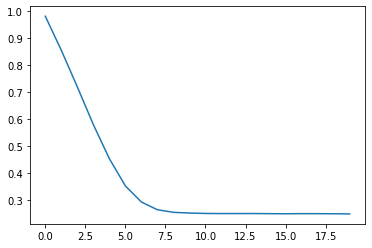

In [230]:
plt.plot(lstm_model.history.history['val_loss'])

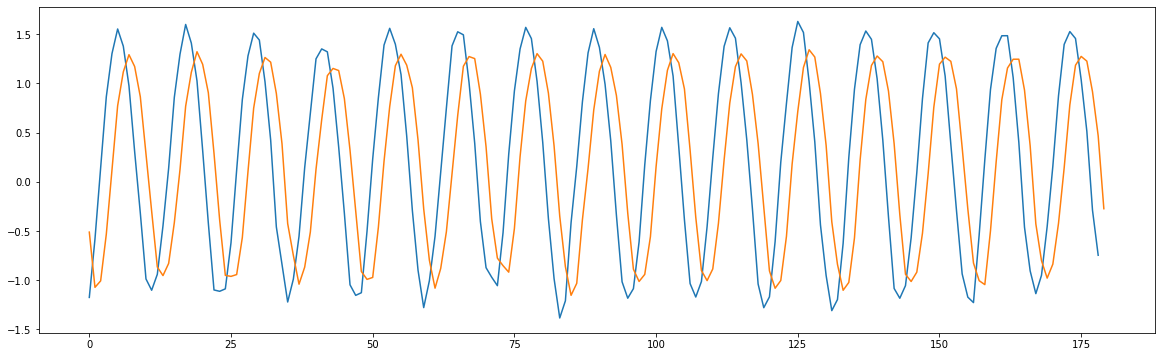

In [231]:
X_test_LSTM = np.insert(X_test,0,X_train[-1][0]).reshape(-1,1)
X_test_LSTM = X_test_LSTM[:,None]
X_test_LSTM.shape
predictions = lstm_model.predict(X_test_LSTM)
plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions)

In [232]:
predictions_inv_scaled = sc.inverse_transform(predictions)
print('MSE: %f'%mean_squared_error(test,predictions_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(test,predictions_inv_scaled)))
print('R-Squared: %f'%r2_score(test,predictions_inv_scaled))

MSE: 4.426921
RMSE: 2.104025
R-Squared: 0.740154


In [234]:
predictions.shape, y_test.shape

((180, 1), (179, 1))

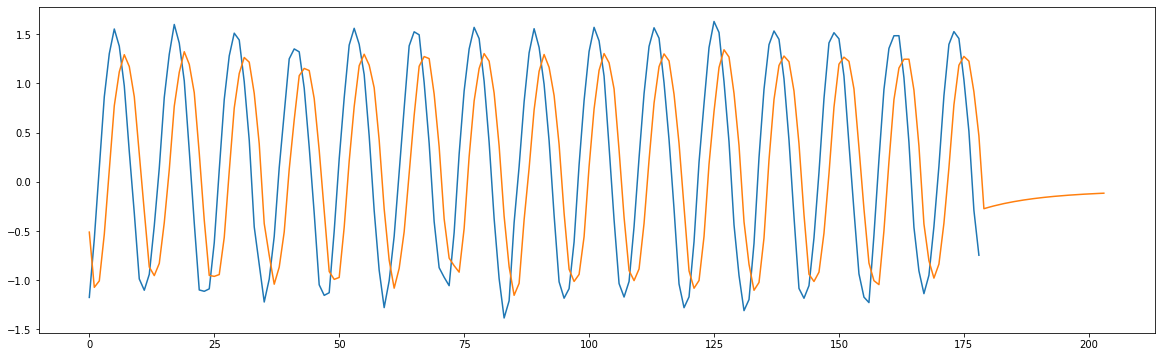

In [235]:
predictions.shape, y_test.shape
last = predictions[-1].reshape(-1,1) # This is the value predicted for 2016

for i in range(24):
    last = last[:, None]
    next_month = lstm_model.predict(last)
    
    predictions=np.append(predictions, next_month)
    
    last = next_month
#print('Prediction for July 2016 is', sc.inverse_transform(last)[0][0])

plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(predictions) 

          

# Using forward windows

It doesn't do much better, right? we will try now  a different approach: use a moving forward window of size 60 (5 years), which means we will use the first 60 data points as out input X to predict y1 — the 61st data point. Next, we will use the window between 1 to 61 data points as input X to predict y2 i.e., the 62nd data point and so on

In [255]:
# Starting from training and test sequences
scaled_train.shape, scaled_test.shape

((1200, 1), (180, 1))

In [256]:
# We build a dataframe with 61 columns where the 61st column is the label we want to predict
window_size = 60
df = pd.DataFrame(np.concatenate((scaled_train, scaled_test)))
df_s = df.copy()
for i in range(window_size):
    df = pd.concat([df, df_s.shift(-(i+1))], axis = 1)
    
df.dropna(axis=0, inplace=True)

In [257]:
# First 60 columns are the features, 61st column is the label
df.shape

(1320, 61)

Now we can split our new dataframe into training and test

In [258]:
# We will be left with 1140 data points to train our models and 180 to validate them
train, test = df.iloc[:-180, :], df.iloc[-180:,:]
train.shape, test.shape

((1140, 61), (180, 61))

In [259]:
# Separating features from labels
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1140, 60), (1140,), (180, 60), (180,))

In [260]:
# We try first with a simple Linear Regression model
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting on all the test data at once
y_pred = regressor.predict(X_test)

In [261]:
# Retrieving temperatures data from the scaled ones

y_pred_inv_scaled = sc.inverse_transform(y_pred)
actuals = sc.inverse_transform(y_test)
actuals.shape

(180,)

In [263]:
print('MSE: %f'%mean_squared_error(actuals, y_pred_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(actuals, y_pred_inv_scaled)))
print('R-Squared: %f'%r2_score(actuals, y_pred_inv_scaled))

MSE: 0.089340
RMSE: 0.298899
R-Squared: 0.994756


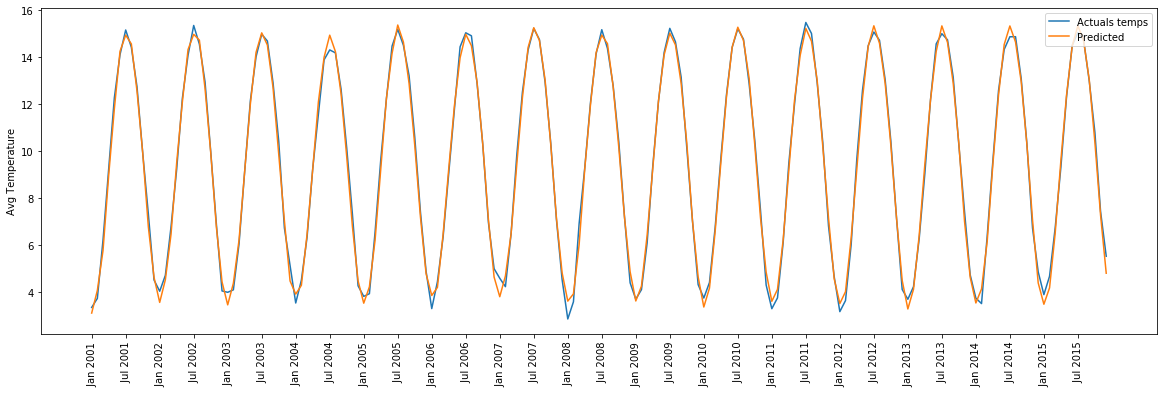

In [299]:
# Visualize Predictions
plt.figure(figsize=(20,6))
plt.ylabel("Avg Temperature")
plt.plot(actuals, label="Actuals temps")
plt.plot(y_pred_inv_scaled, label="Predicted")
plt.legend(loc='upper right')
plt.xticks(ticks=np.arange(180)[::6], labels=pd.date_range(start='2001-01-01', end='2015-12-01', freq = '6MS').strftime(' %b %Y'), rotation="vertical")
plt.show()

From the graph above it looks that the model fits very well the training and validation data, but what about generalizing to new data? we want to predict now temperatures for the next two years: 2016 and 2017


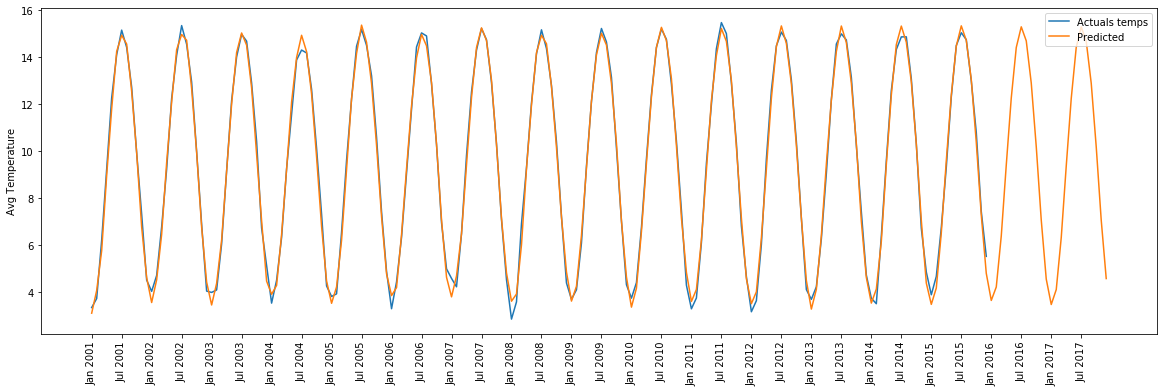

In [311]:
ext_y_pred = y_pred.copy()
last = ext_y_pred[-60:] # This the temperatures predicted in the last 5 years

for i in range(24):
    last = last[None, :]
    next_month = regressor.predict(last)
    ext_y_pred = np.append(ext_y_pred, next_month)
    last = ext_y_pred[-60:]


y_pred_inv_scaled = sc.inverse_transform(ext_y_pred)
actuals = sc.inverse_transform(y_test)       

plt.figure(figsize=(20,6))
plt.ylabel("Avg Temperature")
plt.plot(actuals, label="Actuals temps")
plt.plot(y_pred_inv_scaled, label="Predicted")
plt.legend(loc='upper right')
plt.xticks(ticks=np.arange(len(y_pred_inv_scaled))[::6], labels=pd.date_range(start='2001-01-01', periods=len(y_pred_inv_scaled), freq = '6MS').strftime('%b %Y'), rotation="vertical")
plt.show()

So it seems that the linear regressor can capture the seasonality of the data too.

In [325]:
# What's the average temperature predicted for June 2017? Hint index 180 = Jan 2016

y_pred_inv_scaled[180+5]

14.419550554822795

## Using FF Neural Netowrk

We will now try to predict temperatures using a Feed-Forward Neural Network. This network will of course have 60 input nodes, some hidden layers with relu activation functions, and one output node for the predicted temperature.

In [345]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mse', optimizer='adam')
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               7808      
_________________________________________________________________
dense_28 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 172,673
Trainable params: 172,673
Non-trainable params: 0
_________________________________________________________________


In [346]:
from keras.callbacks.callbacks import ModelCheckpoint
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
NN_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks_list)


Train on 1140 samples, validate on 180 samples
Epoch 1/10
1140/1140 [==============================] - 3s 3ms/step - loss: 0.1467 - val_loss: 0.0331

Epoch 00001: val_loss improved from inf to 0.03312, saving model to Weights-001--0.03312.hdf5
Epoch 2/10
1140/1140 [==============================] - 1s 736us/step - loss: 0.0121 - val_loss: 0.0352

Epoch 00002: val_loss did not improve from 0.03312
Epoch 3/10
1140/1140 [==============================] - 1s 661us/step - loss: 0.0084 - val_loss: 0.0241

Epoch 00003: val_loss improved from 0.03312 to 0.02409, saving model to Weights-003--0.02409.hdf5
Epoch 4/10
1140/1140 [==============================] - 1s 778us/step - loss: 0.0075 - val_loss: 0.0080

Epoch 00004: val_loss improved from 0.02409 to 0.00795, saving model to Weights-004--0.00795.hdf5
Epoch 5/10
1140/1140 [==============================] - 1s 879us/step - loss: 0.0073 - val_loss: 0.0115

Epoch 00005: val_loss did not improve from 0.00795
Epoch 6/10
1140/1140 [================

In [347]:
# Predictions
y_pred = NN_model.predict(X_test)
y_pred_inv_scaled = sc.inverse_transform(y_pred)
actuals = sc.inverse_transform(y_test)
actuals.shape

(180,)

In [348]:
print('MSE: %f'%mean_squared_error(actuals, y_pred_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(actuals, y_pred_inv_scaled)))
print('R-Squared: %f'%r2_score(actuals, y_pred_inv_scaled))

MSE: 0.205599
RMSE: 0.453430
R-Squared: 0.987932


# LSTM

Preparing the 3D input vector for the LSTM. 

Remember, the input vector for LSTM is 3D array: (num_samples, num_time_steps, num_features). In this case we have num of time steps = 50 and num_features = 1 (Extending the same analogy we saw in the previous point, that I found very useful in understanding why the input shape has to be like this — lets say, we have 50 words in one sentence and each word is represented by a word vector. So we need 50 time steps to go through each word vector in the sentence as an input to the LSTM at each time step. There is one sentence per observation and hence num_features = 1. 

In [349]:

#Prepring rank 3 input tensors

train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1140, 60, 1), (1140,), (180, 60, 1), (180,))

In [351]:
train_X.shape[1], train_X.shape[2]

(60, 1)

In [352]:
# Alternative LSTM
from keras.layers.recurrent import LSTM


model = Sequential()
model.add(LSTM(input_shape = (train_X.shape[1], train_X.shape[2]), output_dim=train_X.shape[1], return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.005))
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               324608    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 339,745
Trainable params: 339,745
Non-trainable params: 0
________________________________________________

In [353]:
import time
start = time.time()
model.fit(train_X,train_y, batch_size=128, nb_epoch=20, shuffle=False, validation_data=(test_X, test_y))
#validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Train on 1140 samples, validate on 180 samples
Epoch 1/20
1140/1140 [==============================] - 53s 46ms/step - loss: 0.7907 - val_loss: 0.6390
Epoch 2/20
1140/1140 [==============================] - 33s 29ms/step - loss: 0.4512 - val_loss: 0.1181
Epoch 3/20
1140/1140 [==============================] - 23s 21ms/step - loss: 0.1189 - val_loss: 0.2459
Epoch 4/20
1140/1140 [==============================] - 24s 21ms/step - loss: 0.0771 - val_loss: 0.0976
Epoch 5/20
1140/1140 [==============================] - 25s 22ms/step - loss: 0.0435 - val_loss: 0.0690
Epoch 6/20
1140/1140 [==============================] - 26s 22ms/step - loss: 0.0396 - val_loss: 0.0610
Epoch 7/20
1140/1140 [==============================] - 27s 24ms/step - loss: 0.0358 - val_loss: 0.0480
Epoch 8/20
1140/1140 [==============================] - 27s 24ms/step - loss: 0.0346 - val_loss: 0.0531
Epoch 9/20
1140/1140 [==============================] - 27s 24ms/step - loss: 0.0292 - val_loss: 0.0420
Epoch 10/20
1140/

In [139]:
test_X.shape

(180, 50, 1)

In [263]:
# Doing a prediction on all the test data at once
y_pred = model.predict(test_X)
y_pred_inv_scaled = sc.inverse_transform(y_pred)
actuals = sc.inverse_transform(test_y)
actuals.shape

(180,)

In [264]:
print('MSE: %f'%mean_squared_error(actuals, y_pred_inv_scaled))
print('RMSE: %f'%np.sqrt(mean_squared_error(actuals, y_pred_inv_scaled)))
print('R-Squared: %f'%r2_score(actuals, y_pred_inv_scaled))

MSE: 0.780833
RMSE: 0.883648
R-Squared: 0.954168


That's much better!! Now we want to try to predict more than one time step away.

In [256]:
preds.shape, y_test.shape
last = preds[-50:].reshape(-1,1)
last = last[None, :]
last.shape

(1, 50, 1)

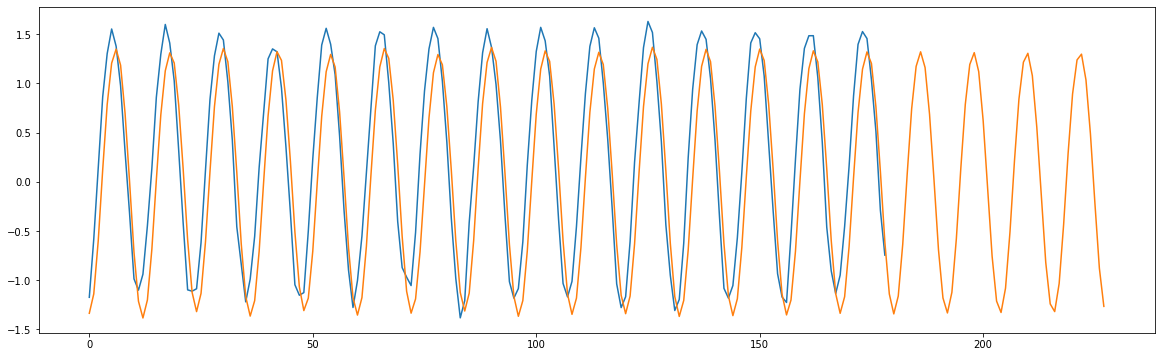

In [267]:
predictions.shape, y_test.shape
last = preds[-50:].reshape(-1,1) # This is the value predicted for 2016

for i in range(24):
    last = last[None, :] 
    next_month = model.predict(last)
    preds=np.append(preds, next_month)
    last = preds[-50:].reshape(-1,1)

plt.figure(figsize=(20,6))
plt.plot(y_test)
plt.plot(preds) 

          

Now that looks much better! The model predicts according to seasonality!

In [148]:
def moving_test_window_preds(model, n_future_preds):

    ''' 
        model - The trained model we are using to predict
        n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = sc.inverse_transform(preds_moving)
    
    return preds_moving

In [149]:
preds_moving = moving_test_window_preds(model, 50)

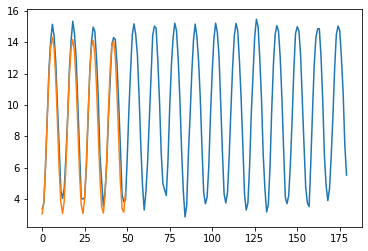

In [152]:
plt.plot(actuals)
plt.plot(preds_moving)
plt.show()

In [154]:
preds_moving = moving_test_window_preds(lstm_model, 50)
plt.plot(actuals)
plt.plot(preds_moving)
plt.show()

NameError: name 'lstm_model' is not defined

In [56]:
# show climate change impact in SA vs (Denmark?)

In [57]:
# How does to relate to some factors that can be changed like CO2 emissions, food production, etc.